# VAE - Hard EM 

In [1]:
import os

os.environ["TPU_CHIPS_PER_HOST_BOUNDS"] = "1,1,1"
os.environ["TPU_HOST_BOUNDS"] = "1,1,1"
# Different per process:
os.environ["TPU_VISIBLE_DEVICES"] = "2"

In [2]:
import hlax
import json
import tomli
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob

In [3]:
%config InlineBackend.figure_format = "retina"

In [4]:
def build_iwmll_df(output_test):
    df_all = []
    for key in output_test:
        df_mll = pd.DataFrame.from_dict(output_test[key])
        df_mll.columns = ["hard-em", "vae"]
        df_mll = pd.DataFrame.from_dict(output_test[key])
        df_mll.columns = [f"hard-em", "vae"]
        df_mll = df_mll.melt(value_name="mll")
        df_mll["episode"] = int(key.lstrip("e"))
        df_all.append(df_mll)
    df_all = pd.concat(df_all, axis=0)
    return df_all

In [229]:
experiments = sorted(glob("../experiments/outputs/*.pkl"))
print(*experiments, sep="\n")

../experiments/outputs/experiment-20221107-063327-mlp.pkl
../experiments/outputs/experiment-20221107-063915-conv.pkl


In [230]:
path_experiment = experiments[-1]
with open(path_experiment, "rb") as f:
    experiment = pickle.load(f)

In [231]:
config = experiment["metadata"]["config"]
config

{'setup': {'dim_latent': 50},
 'train': {'num_obs': 10000,
  'num_epochs': 1000,
  'batch_size': 200,
  'eval_epochs': [2, 10, 100, 250, 500, 1000],
  'learning_rate': 0.0001,
  'vae': {'num_is_samples': 10},
  'hard_em': {'num_its_latent': 10, 'num_its_params': 5}},
 'test': {'num_obs': 1000,
  'num_epochs': 500,
  'learning_rate': 1e-06,
  'num_is_samples': 10}}

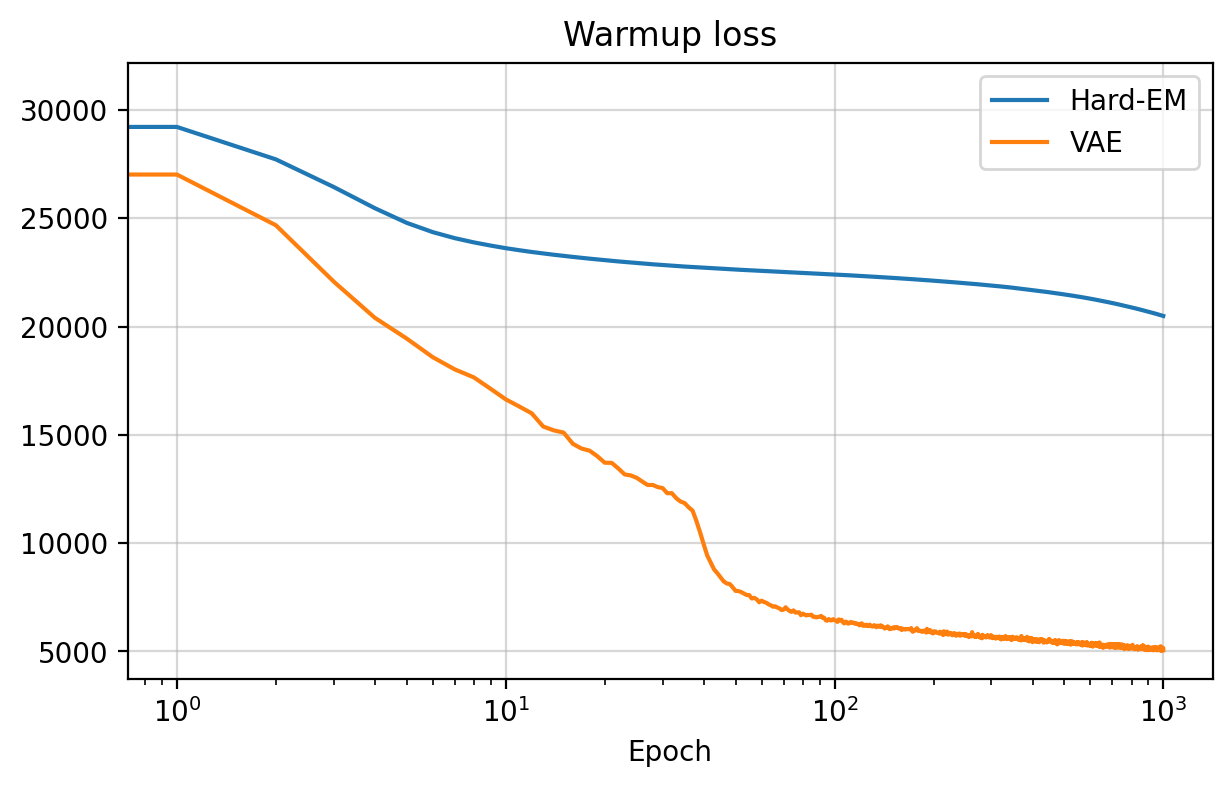

In [232]:
fig, ax = plt.subplots(figsize=(7, 4))
plt.plot(experiment["hardem"]["train"]["hist_loss"], label="Hard-EM")
plt.plot(experiment["vae"]["train"]["hist_loss"], label="VAE")
plt.legend()
plt.title("Warmup loss")
plt.xscale("log")
plt.xlabel("Epoch")
plt.grid(alpha=0.5)

In [233]:
vae_mll = pd.DataFrame(experiment["vae"]["test"]).melt(var_name="episode", value_name="mll")
vae_mll["procedure"] = "VAE"

vae_times = pd.DataFrame.from_dict({"times": experiment["vae"]["train"]["times"]}, orient="index").T
vae_mll = pd.merge(vae_mll, vae_times, left_on="episode", right_index=True)

In [234]:
hardem_mll = pd.DataFrame(experiment["hardem"]["test"]).melt(var_name="episode", value_name="mll")
hardem_mll["procedure"] = "HardEM"

hardem_times = pd.DataFrame.from_dict({"times": experiment["hardem"]["train"]["times"]}, orient="index").T
hardem_mll = pd.merge(hardem_mll, hardem_times, left_on="episode", right_index=True)

In [235]:
df_all = pd.concat([hardem_mll, vae_mll])

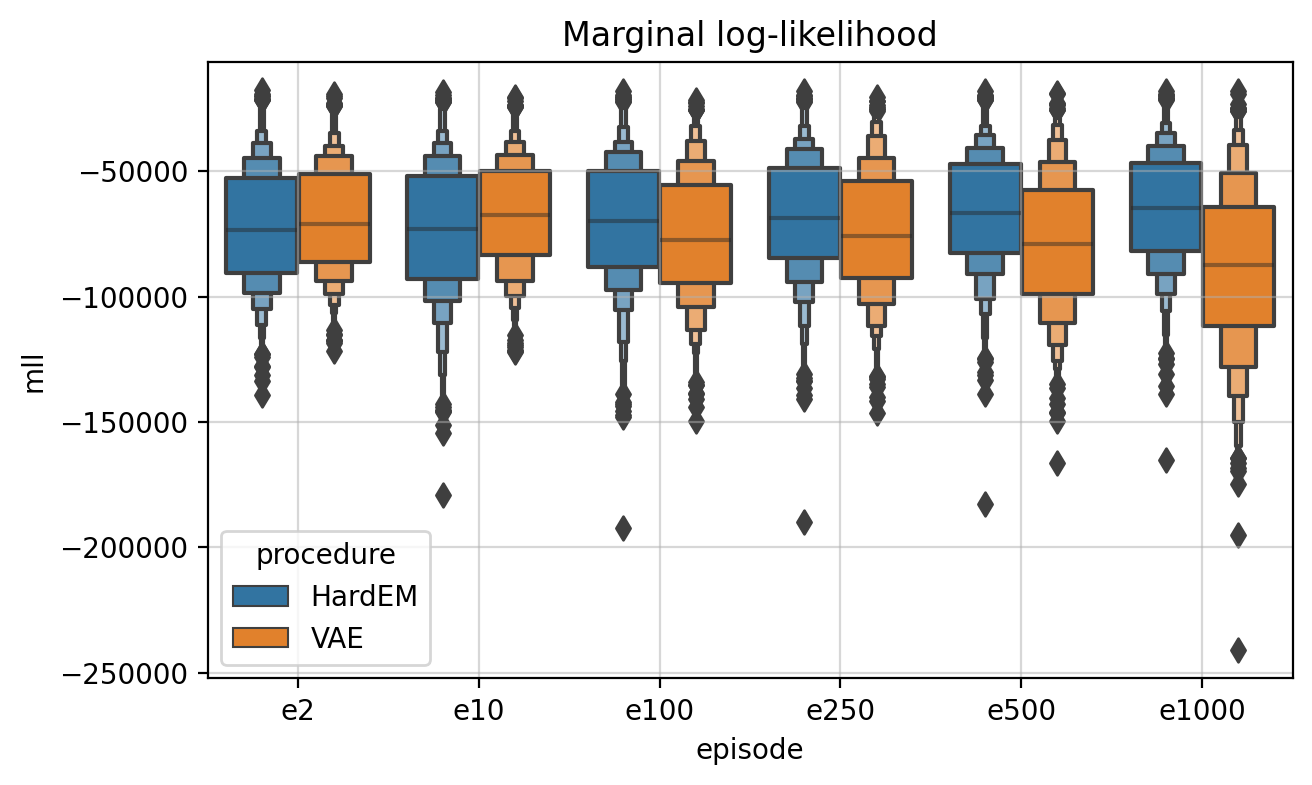

In [236]:
fig, ax = plt.subplots(figsize=(7, 4))
sns.boxenplot(x="episode", y="mll", hue="procedure", data=df_all)
plt.title("Marginal log-likelihood")
plt.grid(alpha=0.5)

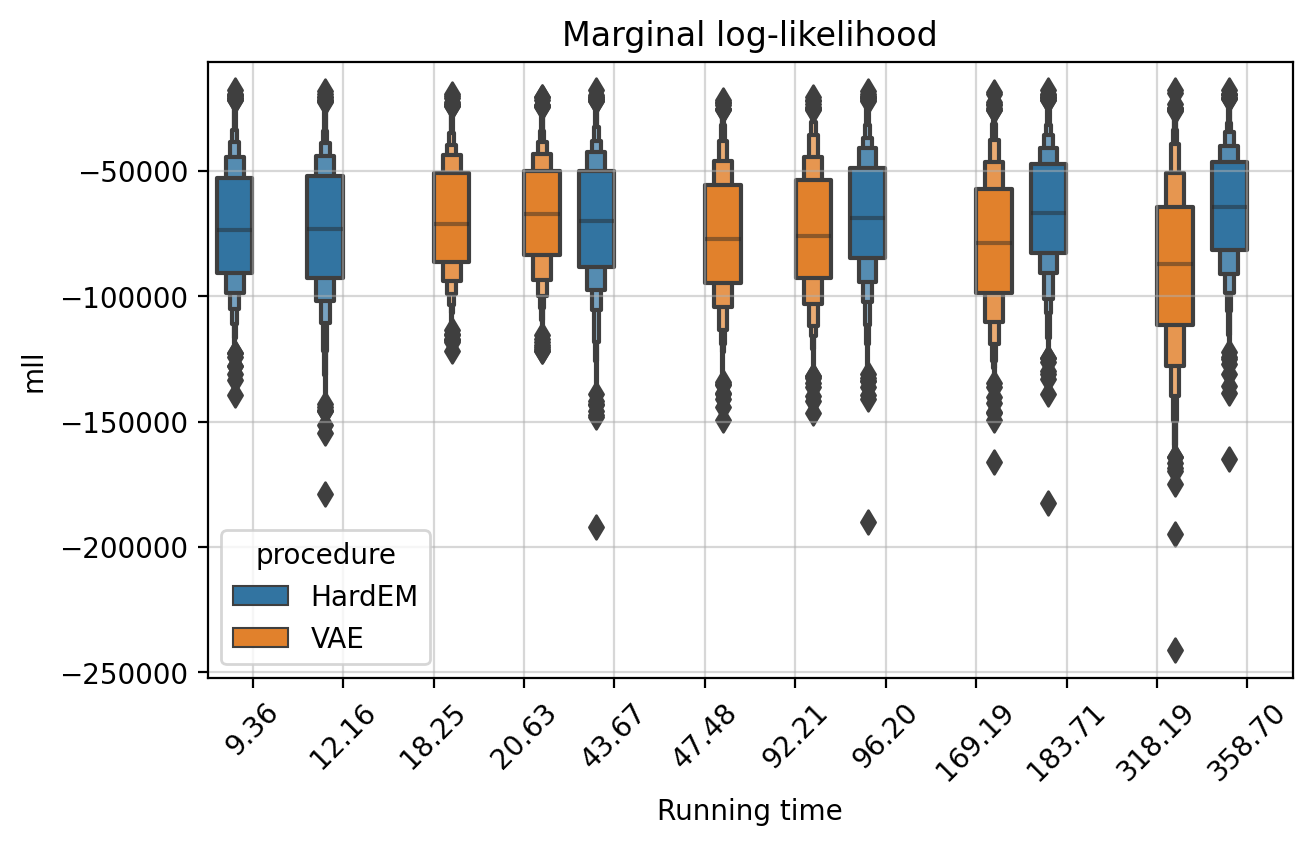

In [245]:
fig, ax = plt.subplots(figsize=(7, 4))
sns.boxenplot(x="times", y="mll", hue="procedure", data=df_all)
xpos, xvals = plt.xticks(rotation=45)
xvals = [f"{float(val.get_text()):0.2f}" for val in xvals]
plt.xticks(xpos, xvals)
plt.title("Marginal log-likelihood")
plt.xlabel("Running time")
plt.grid(alpha=0.5)